A few examples of stacked generalization for classification and regression

Also see [super learner](https://colab.research.google.com/drive/1mggweIDngAj2sfWkkISeQ2PKPrjrzwYs#scrollTo=TBDUuk3nS3Zg)

Reference 
---------
1. [Develop superlearner in Python](https://machinelearningmastery.com/super-learner-ensemble-in-python/)
2. [Sklearn: Comparing comparison](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
   - sklearn's [cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)
   - [model selection](https://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html)
3. [ML Mastery](https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/)

In [8]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
import pandas as pd
from pandas import DataFrame
import os, sys

# Tensorflow
# import tensorflow as tf
# import tensorflow_probability as tfp
# tfd = tfp.distributions
# tf.executing_eagerly()

# Colab 
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Plotting
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
import seaborn as sns
from IPython.display import display

from tqdm import tqdm

### Configure system environment
- Please modify `input_dir` according to your local enviornment

In [9]:
cur_dir = os.getcwd()
project_dir = 'machine_learning_examples/cf_ensemble'
if IN_COLAB: 
    # Run this demo on Google Colab
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Parameters for data
    input_dir = f"/content/drive/MyDrive/Colab Notebooks/{project_dir}"
    # /content/drive/MyDrive/Colab Notebooks/machine_learning_examples/data/data-is-life

    sys.path.append(input_dir)
else: 
    input_dir = cur_dir
    
if input_dir != cur_dir: 
    sys.path.append(input_dir)
    print(f"> Adding {input_dir} to sys path ...")
    print(sys.path)

### Import classifiers

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.metrics._classification import cohen_kappa_score

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

### Generating data
- Also see [this blog on generating synthetic data](https://towardsdatascience.com/https-medium-com-faizanahemad-generating-synthetic-classification-data-using-scikit-1590c1632922)

In [11]:
from sklearn import datasets
from sklearn.datasets import load_iris
from sklearn.datasets import make_classification
from sklearn.datasets import make_regression
import utils_classifier as uc

# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
	return X, y

# get the dataset for regression
def get_regression_dataset():
	X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=1)
	return X, y

#######################################
# X, y = load_iris(return_X_y=True)
X, y = uc.generate_gaussian_quantiles(n_samples=5000, verbose=0)

print(f'> Number of classes: {len(np.unique(y))}')

(5000, 2)
> Number of classes: 2


/Users/pleiadian53/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


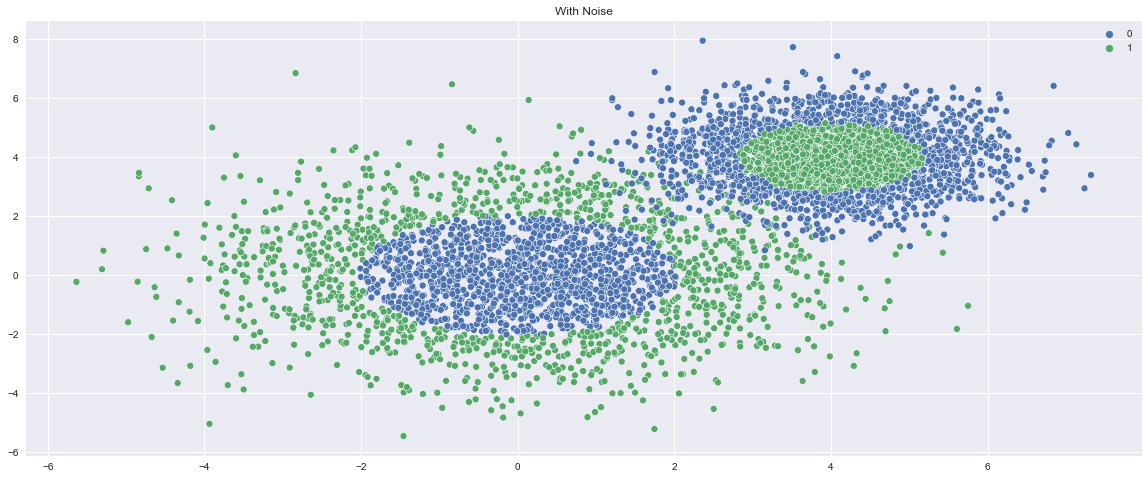

In [12]:
# Plot data
f, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(20,8))
sns.scatterplot(X[:,0],X[:,1],hue=y,ax=ax1);
ax1.set_title("With Noise");
plt.show();

### Simple stacker

In [13]:
# Create Base Learners
base_learners = [
                 ('RF', RandomForestClassifier(n_estimators= 200, 
                                                   oob_score = True, 
                                                   class_weight = "balanced", 
                                                   random_state = 20, 
                                                   ccp_alpha = 0.1)), 
                 ('KNNC', KNeighborsClassifier(n_neighbors = len(np.unique(y))
                                                     , weights = 'distance')),
                #  ('SVC', SVC(kernel = 'linear', probability=True,
                #                    class_weight = 'balanced'
                #                   , break_ties = True)), 

                 ('GNB', GaussianNB()), 
                 ('QDA',  QuadraticDiscriminantAnalysis()), 
                 ('MLPClassifier', MLPClassifier(alpha=1, max_iter=1000)), 
                 # ('DT', DecisionTreeClassifier(max_depth=5)),
                 # ('GPC', GaussianProcessClassifier(1.0 * RBF(1.0))),
                ]

### StackingClassifier
- Base learners are fitted on the full X while the final estimator is trained using cross-validated predictions of the base learners using [cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)

In [14]:
# Initialize Stacking Classifier with the Meta Learner
clf = StackingClassifier(estimators=base_learners, 
                         final_estimator=LogisticRegression())

# Extract score
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
clf.fit(X_train, y_train).score(X_test, y_test)

0.964

### Multi-layer Stacker


In [15]:
# Create Learners per layer
layer_one_estimators = [
                        ('rf_1', RandomForestClassifier(n_estimators=10, random_state=42)),
                        ('knn_1', KNeighborsClassifier(n_neighbors=5))             
                       ]
layer_two_estimators = [
                        ('dt_2', DecisionTreeClassifier()),
                        ('rf_2', RandomForestClassifier(n_estimators=50, random_state=42)),
                       ]

# connect the 2nd layer to the final meta classifier (output layer)
layer_two = StackingClassifier(estimators=layer_two_estimators, final_estimator=LogisticRegression())

# Create Final model by connecting the first layer to the "head" (2nd layer+meta)
clf = StackingClassifier(estimators=layer_one_estimators, final_estimator=layer_two)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
clf.fit(X_train, y_train).score(X_test, y_test)

0.9656

### How does `cross_val_score` work? 

In [16]:
# from sklearn import datasets

X_digits, y_digits = datasets.load_digits(return_X_y=True)
svc = SVC(C=1, kernel='linear')

# Consider 5-fold cross validation
k_fold = KFold(n_splits=5)

# Below two code blocks are equivalent 
scores = [svc.fit(X_digits[train], y_digits[train]).score(X_digits[test], y_digits[test])
              for train, test in k_fold.split(X_digits)] # fit on train split and score/validate on test split in a CV loop
print(scores)

# using cross_val_score
scores2 = cross_val_score(svc, X_digits, y_digits, cv=k_fold, n_jobs=-1) # one-liner for the above
print(list(scores2))

assert np.allclose(scores, scores2)

[0.9638888888888889, 0.9222222222222223, 0.9637883008356546, 0.9637883008356546, 0.9303621169916435]
[0.9638888888888889, 0.9222222222222223, 0.9637883008356546, 0.9637883008356546, 0.9303621169916435]


#### How does `cross_val_predict` work? 
1. [Q&A](https://stackoverflow.com/questions/41458834/how-is-scikit-learn-cross-val-predict-accuracy-score-calculated)

In [17]:
X = np.array([[0], [1], [2], [3], [4], [5]])
labels = np.array(['a', 'a', 'a', 'b', 'b', 'b'])

cv = KFold(n_splits=3) # len(labels)
clf = SVC()
ypred_all = np.chararray((labels.shape))
i = 1
for train_index, test_index in cv.split(X):
    print("iteration", i, ":")
    print("train indices:", train_index)
    print("train data:\n", X[train_index])
    print("test indices:", test_index)
    print("test data:\n", X[test_index])

    clf.fit(X[train_index], labels[train_index]) # fit model on train split
    ypred = clf.predict(X[test_index]) # predict on test split
    print("predicted labels for data of indices", test_index, "are:", ypred)

    ypred_all[test_index] = ypred # <<< collect predictive values and continue to do the same with the other folds
    print("merged predicted labels:", ypred_all)
    i = i+1
    print("=====================================")
y_cross_val_predict = cross_val_predict(clf, X, labels, cv=cv)
print("predicted labels by cross_val_predict:", y_cross_val_predict)

assert y_cross_val_predict.shape[0] == X.shape[0]

iteration 1 :
train indices: [2 3 4 5]
train data:
 [[2]
 [3]
 [4]
 [5]]
test indices: [0 1]
test data:
 [[0]
 [1]]
predicted labels for data of indices [0 1] are: ['b' 'b']
merged predicted labels: [b'b' b'b' b'\x01' b'\x01' b'\x01' b'\x01']
iteration 2 :
train indices: [0 1 4 5]
train data:
 [[0]
 [1]
 [4]
 [5]]
test indices: [2 3]
test data:
 [[2]
 [3]]
predicted labels for data of indices [2 3] are: ['a' 'b']
merged predicted labels: [b'b' b'b' b'a' b'b' b'\x01' b'\x01']
iteration 3 :
train indices: [0 1 2 3]
train data:
 [[0]
 [1]
 [2]
 [3]]
test indices: [4 5]
test data:
 [[4]
 [5]]
predicted labels for data of indices [4 5] are: ['a' 'a']
merged predicted labels: [b'b' b'b' b'a' b'b' b'a' b'a']
predicted labels by cross_val_predict: ['b' 'b' 'a' 'b' 'a' 'a']


### Stacking for classification Part 2

[ML Mastery](https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/)
   - RepeatedStratifiedKFold

[Implement stacking from scratch](https://machinelearningmastery.com/implementing-stacking-scratch-python/)

#### Define and evaluate a set of base models

>lr 0.866 (0.029)
>knn 0.931 (0.025)
>cart 0.827 (0.042)
>svm 0.957 (0.020)
>bayes 0.833 (0.031)


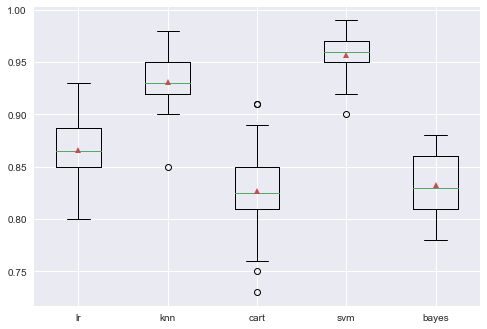

In [18]:
# compare standalone models for binary classification
# from numpy import mean
# from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB

# from matplotlib import pyplot
import matplotlib.pylab as plt

# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	models['lr'] = LogisticRegression()
	models['knn'] = KNeighborsClassifier()
	models['cart'] = DecisionTreeClassifier()
	models['svm'] = SVC()
	models['bayes'] = GaussianNB()
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()

# evaluate the models (base predictors) and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

A box-and-whisker plot is then created comparing the distribution accuracy scores for each model, allowing us to clearly see that KNN and SVM perform better on average than LR, CART, and Bayes.

>lr 0.866 (0.029)
>knn 0.931 (0.025)
>cart 0.826 (0.045)
>svm 0.957 (0.020)
>bayes 0.833 (0.031)
>stacking 0.963 (0.019)


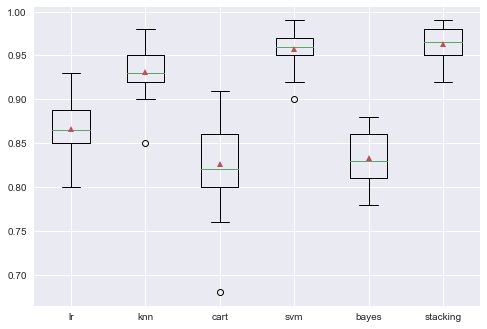

In [19]:
# get a stacking ensemble of models
def get_stacking(base_learners=[], meta_learner=None):
    
	level0 = base_learners
	if not level0: 
		# define the base models
		level0 = list()
		level0.append(('lr', LogisticRegression()))
		level0.append(('knn', KNeighborsClassifier()))
		level0.append(('cart', DecisionTreeClassifier()))
		level0.append(('svm', SVC()))
		level0.append(('bayes', GaussianNB()))
  
	# define meta learner model
	level1 = meta_learner
	if level1 is None: 
	    level1 = LogisticRegression()
 
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

# get a list of models to evaluate and compare
def get_target_models():
	models = dict()
	models['lr'] = LogisticRegression()
	models['knn'] = KNeighborsClassifier()
	models['cart'] = DecisionTreeClassifier()
	models['svm'] = SVC()
	models['bayes'] = GaussianNB()
	models['stacking'] = get_stacking()
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_target_models() # all base models and the stacker

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

#### Predicting a single example

In [20]:
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)

# define the base models
model = get_stacking()

# fit the model on all available data
model.fit(X, y)

# make a prediction for one example
data = [[2.47475454,0.40165523,1.68081787,2.88940715,0.91704519,-3.07950644,4.39961206,0.72464273,-4.86563631,-6.06338084,-1.22209949,-0.4699618,1.01222748,-0.6899355,-0.53000581,6.86966784,-3.27211075,-6.59044146,-2.21290585,-3.139579]]
yhat = model.predict(data)
print('Predicted Class: %d' % (yhat))

Predicted Class: 0


### Stacking for classification Part 3: Preparation for Collaborative Filtering
- See `demo-cf-stacking` notebook for full coverage

In [21]:
import utils_stacking as ustk
import utils_classifier as uclf
import utils_sys as us

from sklearn.metrics import f1_score

n_iter = 0
for i in range(n_iter): 
    # Initialize CF Stacker
    clf = ustk.CFStacker(estimators=base_learners, 
                            final_estimator=LogisticRegression(), 
                            work_dir = input_dir,
                            fold_number = i, # use this to index traing and test data 
                            verbose=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    clf.fit(X_train, y_train)

    X_meta_test = clf.transform(X_test)
    print(f"[info] shape(X_meta_test): {X_meta_test.shape}")

    y_pred = clf.predict(X_test)
    perf_score = f1_score(y_test, y_pred)  # clf.score(X_test, y_test)
    print('[result]', perf_score)

    # Add test label for the convenience of future evaluation after applying a CF ensemble method
    clf.cf_write(dtype='test', y=y_test)

### Stacking for Regression
- RepeatedKFold

In [22]:
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.ensemble import StackingRegressor

>knn -0.140 (0.019)
>cart -0.185 (0.034)
>svm -0.160 (0.012)


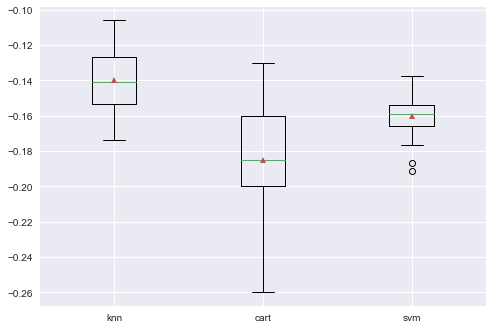

In [23]:
# get a list of models to evaluate
def get_models():
	models = dict()
	models['knn'] = KNeighborsRegressor()
	models['cart'] = DecisionTreeRegressor()
	models['svm'] = SVR()
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In this case, model performance will be reported using the mean absolute error (MAE). The scikit-learn library inverts the sign on this error to make it maximizing, from -infinity to 0 for the best score.

#### Making a stacking regressor

>knn -0.140 (0.019)
>cart -0.181 (0.032)
>svm -0.160 (0.012)
>stacking -0.149 (0.013)


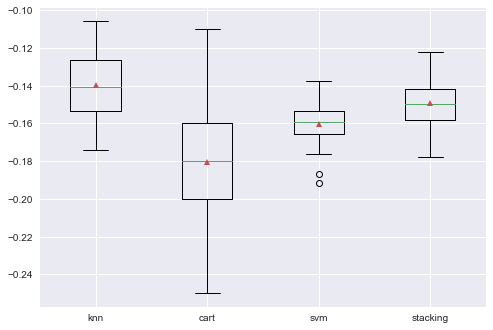

In [24]:
# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('knn', KNeighborsRegressor()))
	level0.append(('cart', DecisionTreeRegressor()))
	level0.append(('svm', SVR()))
	# define meta learner model
	level1 = LinearRegression()
	# define the stacking ensemble
	model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
	return model

# get a list of models to evaluate
def get_models():
	models = dict()
	models['knn'] = KNeighborsRegressor()
	models['cart'] = DecisionTreeRegressor()
	models['svm'] = SVR()
	models['stacking'] = get_stacking()
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

#### Making new predictions

In [25]:
# define the base models
level0 = list()
level0.append(('knn', KNeighborsRegressor()))
level0.append(('cart', DecisionTreeRegressor()))
level0.append(('svm', SVR()))
# define meta learner model
level1 = LinearRegression()
# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
model.fit(X, y)
# make a prediction for one example
data = [[0.59332206,-0.56637507,1.34808718,-0.57054047,-0.72480487,1.05648449,0.77744852,0.07361796,0.88398267,2.02843157,1.01902732,0.11227799,0.94218853,0.26741783,0.91458143,-0.72759572,1.08842814,-0.61450942,-0.69387293,1.69169009]]
yhat = model.predict(data)
print('Predicted Value: %.3f' % (yhat))

Predicted Value: 0.449
